In [1]:
import numpy as np
from tigramite.independence_tests.oracle_conditional_independence import OracleCI
from tigramite import plotting as tp

### Links of the Causal Graph

Links can be initialized as a dictionary with a (key, value) pair for each variable $i$:

$\{i:[(j,0),(k,0)]\}$

where $i$ has $j,k$ as parents at lag 0. 
In this excercise, all causal links are assumed to be at lag 0, i.e., we work with non-time-series data.

In [2]:
#For an unshielded collider links should look as follows:

links = {0 : [(1, 0), (2, 0)], 1: [], 2: []}

### Visualizing the Graph 

Use the functionality of OracleCI to generate a graph corresponding to the links.

Note that the graph is mirror-symmetric around the diagonal, i.e., if $i$ is a parent of $j$ $\Rightarrow$ $j$ is a child of $i$

In [3]:
oracle = OracleCI(links=links)

graph = oracle.graph

print(graph[:, :, 0])

[['' '<--' '<--']
 ['-->' '' '']
 ['-->' '' '']]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

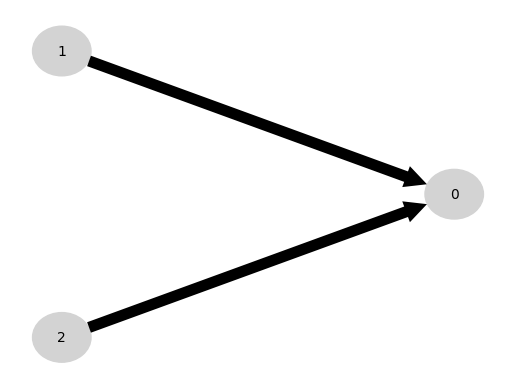

In [4]:
tp.plot_graph(graph = graph)

### Testing for Conditional Independence

Recall that the null hypothesis is (conditional) independence, so:

p-value == 1 $\Rightarrow$ independence

p-value == 0 $\Rightarrow$ dependence

In [5]:
# Test whether 1 and 2 are independent given Z = empty set versus Z = 0. 
_, pval_1 = oracle.run_test(X = [(1,0)], Y = [(2,0)], Z = [])
_, pval_2 = oracle.run_test(X = [(1,0)], Y = [(2,0)], Z = [(0,0)])
pval_1, pval_2

(1.0, 0.0)

### Write a class to run the PC algorithm 
with arguments
1. total number of variables and 

2. oracle object 

In [6]:
encode_rel = lambda c: -1 if c == "<--" else 1 if c == "-->" else 0

class Graph:
    def __init__(self, num_variables: int):
        self.nodes = set(range(num_variables))
        self.edges = {p: self.nodes - set([p]) for p in self.nodes}
    
    def adj(self, p: int):
        return self.edges[p]
    
    def del_adj(self, p: int, q: int):
        if q in self.edges[p]:
            self.edges[p].remove(q)
        
    def __repr__(self) -> str:
        return "Nodes: {}, Edges: {}".format(self.nodes, self.edges)

def combinations(s: set, k: int):
    if k == 0:
        return [set()]
    if len(s) == 0:
        return []
    if len(s) == k:
        return [s]
    x = s.pop()
    s_copy = s.copy()
    s.add(x)
    return combinations(s_copy, k) + [set([x]).union(c) for c in combinations(s_copy, k - 1)]

class PCAlg:
    def __init__(self, num_variables: int, oracle_object: OracleCI, p: float = 0.05):
        self.num_variables = num_variables
        self.oracle_object = oracle_object
        self.p = p
        self.sepset = {}
        self.step1()
        self.step2()
        self.step3()
        
    def step1(self):
        self.graph = Graph(self.num_variables)
        
        for n_adj in range(self.num_variables - 1):
            for y in self.graph.nodes:
                adj_y = self.graph.edges[y]
                adj_yxs = [(x, adj_y - set([x])) for x in adj_y]
                adj_yxs_filtered = [(x, adj_yx) for x, adj_yx in adj_yxs if len(adj_yx) >= n_adj]
                adj_yxs_all_subsets = [(x, adj_yx_subset) for x, adj_yx in adj_yxs_filtered for adj_yx_subset in combinations(adj_yx, n_adj)]               
                for x, adj_y_subset in adj_yxs_all_subsets:
                    _, pval = self.oracle_object.run_test(
                        X = [(x, 0)], 
                        Y = [(y, 0)], 
                        Z = [(z, 0) for z in adj_y_subset]
                    )
                    if pval > self.p:
                        self.graph.del_adj(y, x)
                        self.sepset[(x, y)] = adj_y_subset
        return self
    
    def step2(self):
        triples = []
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                for z in self.graph.edges[y]:
                    if z == x or z in self.graph.edges[x]:
                        continue
                    triples.append((x, y, z))
        
        for x, y, z in triples:
            if y not in self.sepset[(x, z)]:
                self.graph.del_adj(y, x)
                self.graph.del_adj(y, z)
        return self
    
    def step3(self):
        while self.orient1() or self.orient2() or self.orient3():
            pass
        return self
    
    def orient1(self) -> bool:
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                if x in self.graph.edges[y]:
                    continue
                for z in self.graph.edges[y]:
                    if z == x:
                        continue
                    if z in self.graph.edges[x]:
                        continue
                    if y not in self.graph.edges[z]:
                        continue
                    self.graph.del_adj(z, y)        
                    return True
        return False
    
    def orient2(self) -> bool:              
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                if x in self.graph.edges[y]:
                    continue
                for z in self.graph.edges[y]:
                    if z == x:
                        continue
                    if y in self.graph.edges[z]:
                        continue
                    if x not in self.graph.edges[z] or z not in self.graph.edges[x]:
                        continue
                    self.graph.del_adj(z, x)
                    return True
        return False
    
    def orient3(self) -> bool:  
        for x in self.graph.nodes:
            for y in self.graph.edges[x]:
                if x not in self.graph.edges[y]:
                    continue
                for z in self.graph.edges[x]:
                    if x not in self.graph.edges[z]:
                        continue
                    if z == y:
                       continue 
                    if z in self.graph.edges[y] or y in self.graph.edges[z]:
                        continue
                    for w in self.graph.edges[x]:
                        if x not in self.graph.edges[w]:
                            continue
                        if w == y or w == z:
                            continue 
                        if y in self.graph.edges[w] or z in self.graph.edges[w]:
                            continue
                        self.graph.del_adj(w, x)
                        return True
        return False

### Test your PC algorithm on this causal graph (aka Y-structure):
links =  {0: [], 1: [], 2: [(0,0), (1,0)], 3: [(2,0)]}

(<Figure size 640x480 with 1 Axes>, <Axes: >)

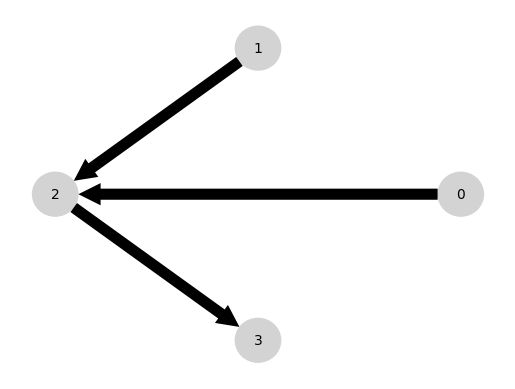

In [7]:
links = {0: [], 1: [], 2: [(0,0), (1,0)], 3: [(2,0)]}
oracle = OracleCI(links=links)
tp.plot_graph(graph = oracle.graph[:, :, 0])

In [8]:
pc = PCAlg(4, oracle)
print(pc.graph)

Nodes: {0, 1, 2, 3}, Edges: {0: {2}, 1: {2}, 2: {3}, 3: set()}
